# FYI directions, delete later

You are to build upon the predictive analysis (classification) that you already completed in the previous mini-project, adding additional modeling from new classification algorithms as well as more explanations that are inline with the CRISP-DM framework. You should use appropriate cross validation for all of your analysis (explain your chosen method of performance validation in detail). Try to use as much testing data as possible in a realistic manner (you should define what you think
is realistic and why). 

This report is worth 20% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a single document. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the rendered Jupyter notebook. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

Dataset Selection

Select a dataset identically to the way you selected for the first project work week and mini-project.
You are not required to use the same dataset that you used in the past, but you are encouraged.
You must identify two tasks from the dataset to regress or classify. That is:

* two classification tasks OR
* two regression tasks OR
* one classification task and one regression task

For example, if your dataset was from the diabetes data you might try to predict two tasks: (1)
classifying if a patient will be readmitted within a 30 day period or not, and (2) regressing what the
total number of days a patient will spend in the hospital, given their history and specifics of the
encounter like tests administered and previous admittance.

# Lab 2: Zillow Dataset Classification 
MSDS 7331 Data Mining - Section 403 - Lab 2

Team: Ivelin Angelov, Yao Yao, Kaitlin Kirasich, Albert Asuncion

<a id="top"></a>
## Contents
* <a href="#Imports">Imports</a>
* <a href="#Define">Define and Prepare Class Variables</a>
* <a href="#Describe">Describe the Final Dataset</a>
* <a href="#Evaluation">Explain Evaluation Metrics</a>
* <a href="#Splits">Training and Testing Splits</a>
* <a href="#Models">Three Different Classification/Regression Models</a>
* <a href="#Analysis">Visualizations of Results and Analysis</a>
* <a href="#Advantages">Advantages of Each Model</a>
* <a href="#Attributes">Important Attributes</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>
* <a href="#References">References</a>
________________________________________________________________________________________________________
<a id="Imports"></a>
# Imports & Utils

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

def output_variables_table(variables):
    variables = variables.sort_index()
    rows = ['<tr><th>Variable</th><th>Type</th><th>Scale</th><th>Description</th></tr>']
    for vname, atts in variables.iterrows():
        if vname not in dataset.columns:
            continue
        atts = atts.to_dict()
        # add scale if TBD
        if atts['scale'] == 'TBD':
            if atts['type'] in ['nominal', 'ordinal']:
                uniques = dataset[vname].unique()
                uniques = list(uniques.astype(str))
                if len(uniques) < 10:
                    atts['scale'] = '[%s]' % ', '.join(uniques)
                else:
                    atts['scale'] = '[%s]' % (', '.join(uniques[:5]) + ', ... (%d More)' % len(uniques))
            if atts['type'] in ['ratio', 'interval']:
                atts['scale'] = '(%d, %d)' % (dataset[vname].min(), dataset[vname].max())
        row = (vname, atts['type'], atts['scale'], atts['description'])
        rows.append('<tr><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>' % row)
    return HTML('<table>%s</table>' % ''.join(rows))


# Define an accuracy plot
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
# Plot the feature importances of the forest
def plot_feature_importance(ytrue,yhat,rt, title=''):
    importances = rt.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rt.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
def print_accuracy(model, y_test, yhat):
    print (model + ' Accuracy', mt.accuracy_score(y_test, yhat))
    prf = mt.precision_recall_fscore_support(y_test, yhat, average='macro')
    print(model + ' Precision', prf[0])
    print(model + ' Recall', prf[1])
    print(model + ' F-measure', prf[2])
    plot_class_acc(y_test,yhat,title=model +" Raw")
    
def get_dataset_subset(dataset, n=1000):
    return {
        'X': dataset['X'].iloc[:n],
        'y': dataset['y'].iloc[:n]
    }

<a href="#top">Back to Top</a>
<a id="Define"></a>
# Define and Prepare Class Variables
<b>10 points</b>

<i>
<b>Description:</b><br/>
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
</i>

## Classification Dataset

In [2]:
variables = pd.read_csv('../../datasets/variables.csv').set_index('name')
dataset = pd.read_csv('../../datasets/train.csv', low_memory=False)

# remove unneeded variables
del dataset['logerror']
del dataset['transactiondate']
del dataset['city']
del dataset['price_per_sqft']


# delete all location information because we want to predict the couty
# and those feature will give it up to easy
y = dataset['regionidcounty'].copy()
del dataset['regionidcounty']
del dataset['regionidcity']
del dataset['regionidzip']
del dataset['regionidneighborhood']
del dataset['rawcensustractandblock']
del dataset['latitude']
del dataset['longitude']

output_variables = output_variables_table(variables)

nominal = variables[variables['type'].isin(['nominal'])]
nominal = nominal[nominal.index.isin(dataset.columns)]
continuous = variables[~variables['type'].isin(['nominal'])]
continuous = continuous[continuous.index.isin(dataset.columns)]

nominal_data = dataset[nominal.index]
nominal_data = pd.get_dummies(nominal_data, drop_first=True)
nominal_data = nominal_data[nominal_data.columns[~nominal_data.columns.isin(nominal.index)]]

continuous_data = dataset[continuous.index]

dataset = pd.concat([continuous_data, nominal_data], axis=1)

columns = dataset.columns
variables = variables[variables.index.isin(dataset.columns)]

# shuffle the dataset (just in case)
dataset = dataset.sample(frac=1)

X = dataset
dataset_class = {
    'X': X,
    'y': y
}
print(y.groupby(y).size())
output_variables

regionidcounty
1286    35417
2061    10261
3101    71083
Name: regionidcounty, dtype: int64


Variable,Type,Scale,Description
airconditioningtypeid,nominal,"[0, 1, 5, 13, 11, 9, 3]",Type of cooling system present in the home (if any)
assessmentyear,interval,"(2015, 2015)",The year of the property tax assessment
bathroomcnt,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[3, 2, 4, 5, 6, ... (17 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[7, 4, 10, 1, 8, 12, 6, 11]",Overall assessment of condition of the building from best (lowest) to worst (highest)
calculatedbathnbr,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathroom
calculatedfinishedsquarefeet,ratio,"(0, 10925)",Calculated total finished living area of the home
censustractandblock,nominal,"[61110023618600.0, 61110015230000.0, 61110006841300.0, 61110052978700.0, 61110040395800.0, ... (445 More)]",Census tract and block ID combined - also contains blockgroup assignment by extension
finishedsquarefeet12,ratio,"(0, 6615)",Finished living area
finishedsquarefeet50,ratio,"(0, 8352)",Size of the finished living area on the first (entry) floor of the home


## Regression Dataset

In this dataset we will predict the value of taxamount

Variable,Type,Scale,Description
airconditioningtypeid,nominal,"[0, 1, 5, 13, 11, 9, 3]",Type of cooling system present in the home (if any)
assessmentyear,interval,"(2015, 2015)",The year of the property tax assessment
bathroomcnt,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[3, 2, 4, 5, 6, ... (17 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[7, 4, 10, 1, 8, 12, 6, 11]",Overall assessment of condition of the building from best (lowest) to worst (highest)
calculatedbathnbr,ordinal,"[2.5, 1.0, 2.0, 1.5, 3.0, ... (23 More)]",Number of bathrooms in home including fractional bathroom
calculatedfinishedsquarefeet,ratio,"(0, 10925)",Calculated total finished living area of the home
censustractandblock,nominal,"[61110023618600.0, 61110015230000.0, 61110006841300.0, 61110052978700.0, 61110040395800.0, ... (445 More)]",Census tract and block ID combined - also contains blockgroup assignment by extension
finishedsquarefeet12,ratio,"(0, 6615)",Finished living area
finishedsquarefeet50,ratio,"(0, 8352)",Size of the finished living area on the first (entry) floor of the home


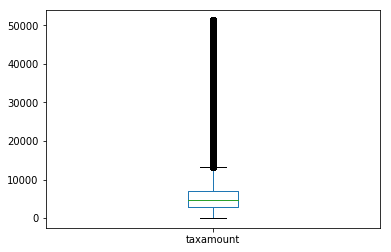

In [3]:
variables = pd.read_csv('../../datasets/variables.csv').set_index('name')
dataset = pd.read_csv('../../datasets/train.csv', low_memory=False)

# remove unneeded variables
del dataset['logerror']
del dataset['transactiondate']
del dataset['city']
del dataset['price_per_sqft']

output_variables = output_variables_table(variables)

nominal = variables[variables['type'].isin(['nominal'])]
nominal = nominal[nominal.index.isin(dataset.columns)]
continuous = variables[~variables['type'].isin(['nominal'])]
continuous = continuous[continuous.index.isin(dataset.columns)]

nominal_data = dataset[nominal.index]
nominal_data = pd.get_dummies(nominal_data, drop_first=True)
nominal_data = nominal_data[nominal_data.columns[~nominal_data.columns.isin(nominal.index)]]

continuous_data = dataset[continuous.index]

dataset = pd.concat([continuous_data, nominal_data], axis=1)

columns = dataset.columns
variables = variables[variables.index.isin(dataset.columns)]

# shuffle the dataset (just in case)
dataset = dataset.sample(frac=1)

X = dataset
y = X['taxamount'].copy()
del X['taxamount']
# del X['taxvaluedollarcnt']????

dataset_reg = {
    'X': X,
    'y': y
}
y.plot(kind='box')
output_variables

In [4]:
dataset_class = get_dataset_subset(dataset_class, 1000)
#dataset_reg = get_dataset_subset(dataset_reg, 5000)

<a href="#top">Back to Top</a>
<a id="Describe"></a>
# Describe the Final Dataset
<b>5 points</b>

<i>
<b>Description:</b><br/>
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
</i>

<a href="#top">Back to Top</a>
<a id="Evaluation"></a>
# Explain Evaluation Metrics
<b>10 points</b>

<i>
<b>Description:</b><br/>
Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
</i>

For our evaluation, we will be taking into account the accuracy and F-measure.  In order to compute the F-measure, we will need the precision and recall.  Because F-measure is a weighted average of these, we think a better F-measure score means the model has a better precision and recall.

Accuracy is the number of true positives and true negatives divided by the total results.  We want to look at accuracy because we it is a good general statistic for our results.

Precision is the number of true positives divided by the total number of positive results we found.  In other words, precision is how well we can predict a positive correctly.  We care about this because we think this value will reflect the quality of our models.

Recall is the number of true positives divided by the sum of true positives and false negatives.  The consequences of type 2 errors, predicting a false negative, are not extreme so we think recall is an appropriate measure of completeness.

Finally, we will also use F-measure which is essentially a weighted average of the precision and recall into one a simple statistic. This will be a number between 0 and 1 where closer to 1 is better and approaching 0 is worse.

<a href="#top">Back to Top</a>
<a id="Imports"></a>
# Training and Testing Splits
<b>10 points</b>

<i>
<b>Description:</b><br/>
Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</i>

# TODO build chart of train size while accuracy continues to increase

We have a large dataset so 10 fold cross validation may take too long.  Because of this, we will be splitting our dataset into 80% train and 20% test.

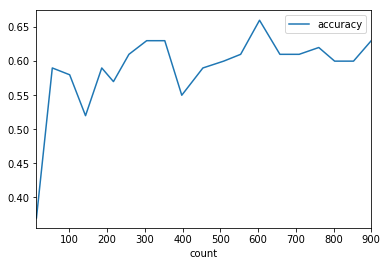

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt

X = dataset_class['X']
y = dataset_class['y']
X, X_test, y, y_test = train_test_split(X, y, test_size=.1, random_state=0)

result = []

# uniform distribution values between 0 and 1
mask = np.random.rand(len(X))

for frac in np.linspace(.01, 1, 20):
    mask_frac = mask<=frac
    X_frac = X[mask_frac]
    y_frac = y[mask_frac]

    clf = RandomForestClassifier()
    clf.fit(X_frac, y_frac)
    y_hat = clf.predict(X_test)
    
    result.append({
        'accuracy': mt.accuracy_score(y_test, y_hat),
        'count': len(X_frac),
        'frac': frac
    })

pd.DataFrame(result).plot('count', 'accuracy')

<a href="#top">Back to Top</a>
<a id="Models"></a>
# Three Different Classification/Regression Models
<b>20 points</b>

<i>
<b>Description:</b><br/>
Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
</i>

## Kaitlin - 3 classification models

# Dummy model
This model is only predicting the most frequent class. It is used for a base line.

Dummy Accuracy 0.69
Dummy Precision 0.23
Dummy Recall 0.333333333333
Dummy F-measure 0.272189349112


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


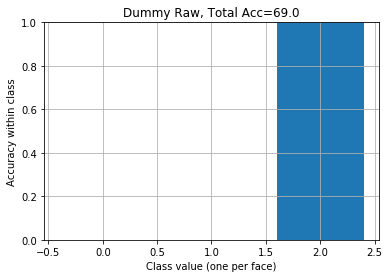

In [6]:
print_accuracy('Dummy', y, [3101] * len(y))

# KNN

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


KNN accuracy 0.517777777778
KNN accuracy 0.414444444444
KNN accuracy 0.563333333333
KNN accuracy 0.554444444444
KNN accuracy 0.598888888889
KNN accuracy 0.607777777778
KNN accuracy 0.624444444444
KNN accuracy 0.631111111111
KNN accuracy 0.658888888889
KNN accuracy 0.657777777778
KNN accuracy 0.674444444444
Accuracy: 0.59 (+/- 0.14)
KNeighborsClassifier Accuracy 0.674444444444
KNeighborsClassifier Precision 0.347162686263
KNeighborsClassifier Recall 0.34500805153
KNeighborsClassifier F-measure 0.312299257789


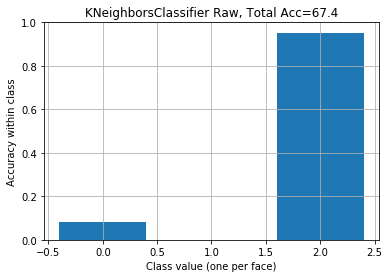

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold

scores = []
for n_neighbors in range(1,12):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    total_accuracy = mt.accuracy_score(y, yhat)
    print ('KNN accuracy', total_accuracy)
    scores.append(total_accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('KNeighborsClassifier', y, yhat)

1.0 Accuracy 0.69
2.9 Accuracy 0.69
4.8 Accuracy 0.69
6.7 Accuracy 0.69
8.6 Accuracy 0.688888888889
10.5 Accuracy 0.687777777778
12.4 Accuracy 0.687777777778
14.3 Accuracy 0.684444444444
16.2 Accuracy 0.677777777778
18.1 Accuracy 0.682222222222
20.0 Accuracy 0.678888888889
Accuracy: 0.69 (+/- 0.01)
RandomForestClassifier Accuracy 0.678888888889
RandomForestClassifier Precision 0.259282009282
RandomForestClassifier Recall 0.329164989265
RandomForestClassifier F-measure 0.272778218483


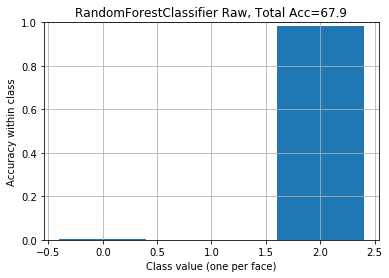

In [8]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

scores = []
for max_depth in np.linspace(1, 20, 11):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = RandomForestClassifier(max_depth=max_depth)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    total_accuracy = mt.accuracy_score(y, yhat)
    print (max_depth, 'Accuracy', total_accuracy)
    scores.append(total_accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('RandomForestClassifier', y, yhat)

1.0 Accuracy 0.207777777778
2.9 Accuracy 0.333333333333
4.8 Accuracy 0.352222222222
6.7 Accuracy 0.424444444444
8.6 Accuracy 0.418888888889
10.5 Accuracy 0.464444444444
12.4 Accuracy 0.524444444444
14.3 Accuracy 0.542222222222
16.2 Accuracy 0.553333333333
18.1 Accuracy 0.582222222222
20.0 Accuracy 0.614444444444
Accuracy: 0.46 (+/- 0.24)
RandomForestClassifier Accuracy 0.614444444444
RandomForestClassifier Precision 0.334393947381
RandomForestClassifier Recall 0.342104699965
RandomForestClassifier F-measure 0.329530832571


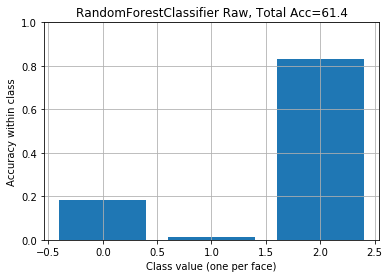

In [13]:
scores = []
for max_depth in np.linspace(1, 20, 11):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = RandomForestClassifier(max_depth=max_depth, class_weight="balanced")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    total_accuracy = mt.accuracy_score(y, yhat)
    print (max_depth, 'Accuracy', total_accuracy)
    scores.append(total_accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('RandomForestClassifier', y, yhat)

In [ ]:
class_weight="balanced_subsample" best Accuracy score was 60.3.
class_weight="balanced" best Accuracy score was 61.4.

# Feature importance of Random Forest

Random Forest Feature ranking:
1. feature 20 (0.083892)
2. feature 4 (0.062748)
3. feature 23 (0.060021)
4. feature 12 (0.059528)
5. feature 22 (0.058795)
6. feature 5 (0.056322)
7. feature 26 (0.054435)


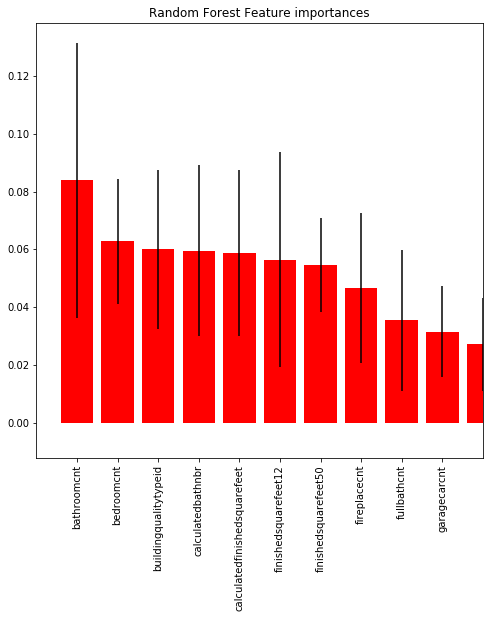

In [10]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Random Forest Feature ranking:")
for f in range(X.shape[1]):
    if importances[indices[f]] > 0.05:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(8,8))
plt.title("Random Forest Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
feature_names = X.columns
plt.xticks(range(10), feature_names)
plt.xticks(rotation=90)
plt.xlim([-1, 10])
plt.show()

0.001 Accuracy 0.368888888889
0.112 Accuracy 0.37
0.223 Accuracy 0.368888888889
0.334 Accuracy 0.368888888889
0.445 Accuracy 0.368888888889
0.556 Accuracy 0.368888888889
0.667 Accuracy 0.368888888889
0.778 Accuracy 0.368888888889
0.889 Accuracy 0.368888888889
1.0 Accuracy 0.368888888889
Accuracy: 0.37 (+/- 0.00)
RandomForestClassifier Accuracy 0.368888888889
RandomForestClassifier Precision 0.338494478542
RandomForestClassifier Recall 0.345423353138
RandomForestClassifier F-measure 0.306698377606


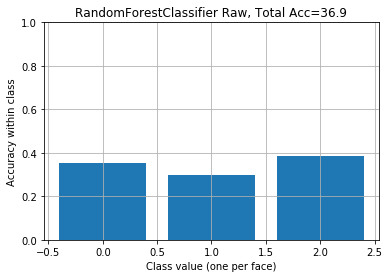

In [11]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

scores = []
for alpha in np.linspace(0.001, 1.0, 10):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = MultinomialNB(alpha=alpha)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    total_accuracy = mt.accuracy_score(y, yhat)
    print (alpha, 'Accuracy', total_accuracy)
    scores.append(total_accuracy)
    
scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('RandomForestClassifier', y, yhat)

<a href="#top">Back to Top</a>
<a id="Analysis"></a>
# Visualizations of Results and Analysis
<b>10 points</b>

<i>
<b>Description:</b><br/>
Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
</i>

# TODO ROC Curv
We choose for a best classification model a Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
    
yhat = np.zeros(y.shape) # we will fill this with predictions
cv = StratifiedKFold(n_splits=5)
for train_index, test_index in cv.split(X, y):
    clf = RandomForestClassifier(max_depth=max_depth)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)

print_accuracy('RandomForestClassifier', y, yhat)

pd.DataFrame(confusion_matrix(y, yhat))

We choose for a best regression model a Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold


X = dataset_reg['X']
y = dataset_reg['y']

yhat = np.zeros(y.shape) # we will fill this with predictions
cv = KFold(n_splits=10)
for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reg = RandomForestRegressor(max_depth=10)
    reg.fit(X_train, y_train)
    yhat[test_index] = reg.predict(X_test)

print('R2:', mt.r2_score(y, yhat))
print('mean_squared_error:', mt.mean_squared_error(y, yhat))

result = pd.DataFrame(yhat, columns=['yhat'])
result['y'] = y.values
result.plot(kind='box');

<a href="#top">Back to Top</a>
<a id="Advantages"></a>
# Advantages of Each Model
<b>10 points</b>

<i>
<b>Description:</b><br/>
Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
</i>

<a href="#top">Back to Top</a>
<a id="Attributes"></a>
# Important Attributes
<b>10 points</b>

<i>
<b>Description:</b><br/>
Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
</i>

<a href="#top">Back to Top</a>
<a id="Deployment"></a>
# Deployment
<b>5 points</b>

<i>
<b>Description:</b><br/>
How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</i>

<a href="#top">Back to Top</a>
<a id="Exceptional"></a>
# Exceptional Work
<b>10 points</b>

<i>
<b>Description:</b><br/>
You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?
</i>

<a href="#top">Back to Top</a>
<a id="References"></a>
# References:

- Kernels from Kaggle competition: https://www.kaggle.com/c/zillow-prize-1/kernels
- Scikitlearn logistic regression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Scikitlearn linear SVC: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- Stackoverflow pandas questions: https://stackoverflow.com/questions/tagged/pandas